# References

Water data library
https://github.com/jjgomera/iapws

Convection heat transfer coefficient calculator
https://calcdevice.com/forced-convection-of-inner-pipe-surface-id130.html


In [1]:
%matplotlib widget

# Thermal simulation of heat exchanger for steady water heating

import copy
from dataclasses import dataclass
from math import pi
import time
from functools import wraps
import math

import multiprocessing.shared_memory
import ray

import numpy as np
import iapws

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter

plt.style.use('dark_background')


In [2]:
ray.init(num_cpus=16)

2023-12-06 11:12:11,090	INFO worker.py:1673 -- Started a local Ray instance.


Python version:,3.11.1
Ray version:,2.8.0


In [3]:
class water:

    linspace_min: int = 5
    linspace_max: int = 95
    linspace_ammount: int = 91
    linspace_step: float = (linspace_max - linspace_min) / (linspace_ammount - 1)
    
    temperature: float = np.linspace(linspace_min, linspace_max, linspace_ammount) # degC
    rho_lt = []
    viscosity_lt = []
    k_lookuptable = []
    cp_lookuptable = []

    pressure = 0.1 # MPa


    @classmethod
    def interpolate(cls, temperature_degC):
        index = math.trunc((temperature_degC - cls.linspace_min)/cls.linspace_step)
        return cls.rho_lt[index] + (cls.rho_lt[index+1] - cls.rho_lt[index]) * (temperature_degC - cls.temperature[index]) / (cls.temperature[index+1] - cls.temperature[index])

    @classmethod
    def init_lookup_tables(cls):
        cls.rho_lt = [iapws.IAPWS95(P=0.1, T = temperature_degC+273.13).rho for temperature_degC in cls.temperature]
        cls.viscosity_lt = [iapws._iapws._Viscosity(iapws.IAPWS95(P=0.1, T = temperature_degC+273.13).rho, temperature_degC + 273.13) for temperature_degC in cls.temperature]
        cls.k_lookuptable = [iapws.IAPWS95(P=0.1, T = temperature_degC+273.13).k for temperature_degC in cls.temperature]
        cls.cp_lookuptable = [iapws.IAPWS95(P=0.1, T = temperature_degC+273.13).cp*1000 for temperature_degC in cls.temperature]

    @classmethod
    def iapws_rho(cls, temperature_degC: float) -> float: # kg/m^3
        return  iapws.IAPWS95(P=cls.pressure, T = temperature_degC+273.13).rho

    @classmethod
    def iapws_viscosity(cls, temperature_degC: float) -> float: # Pa*s
        return iapws._iapws._Viscosity(iapws.IAPWS95(P=cls.pressure, T = temperature_degC+273.13).rho, temperature_degC + 273.13)

    @classmethod
    def iapws_k(cls, temperature_degC: float) -> float: # W/m/K
        return iapws.IAPWS95(P=cls.pressure, T = temperature_degC+273.13).k
    
    @classmethod
    def iapws_cp(cls, temperature_degC: float) -> float: # J/kg/K
        return iapws.IAPWS95(P=cls.pressure, T = temperature_degC+273.13).cp*1000

    @classmethod
    def rho(cls, temperature_degC: float) -> float:
        #return 996.0
        return cls.rho_lt[math.trunc((temperature_degC)/cls.linspace_step)]
    
    @classmethod
    def viscosity(cls, temperature_degC: float) -> float:
        return cls.viscosity_lt[math.trunc((temperature_degC)/cls.linspace_step)]
    
    @classmethod
    def k(cls, temperature_degC: float) -> float:
        return cls.k_lookuptable[math.trunc((temperature_degC - cls.linspace_min)/cls.linspace_step)]


    @classmethod
    def cp(cls, temperature_degC: float) -> float:
        #return 4180.0
        return cls.cp_lookuptable[math.trunc((temperature_degC - cls.linspace_min)/cls.linspace_step)]

water.init_lookup_tables()

[ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22.
 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40.
 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58.
 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76.
 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90. 91. 92. 93. 94.
 95.]
6.0


Text(0.5, 1.0, 'Specific heat capacity')

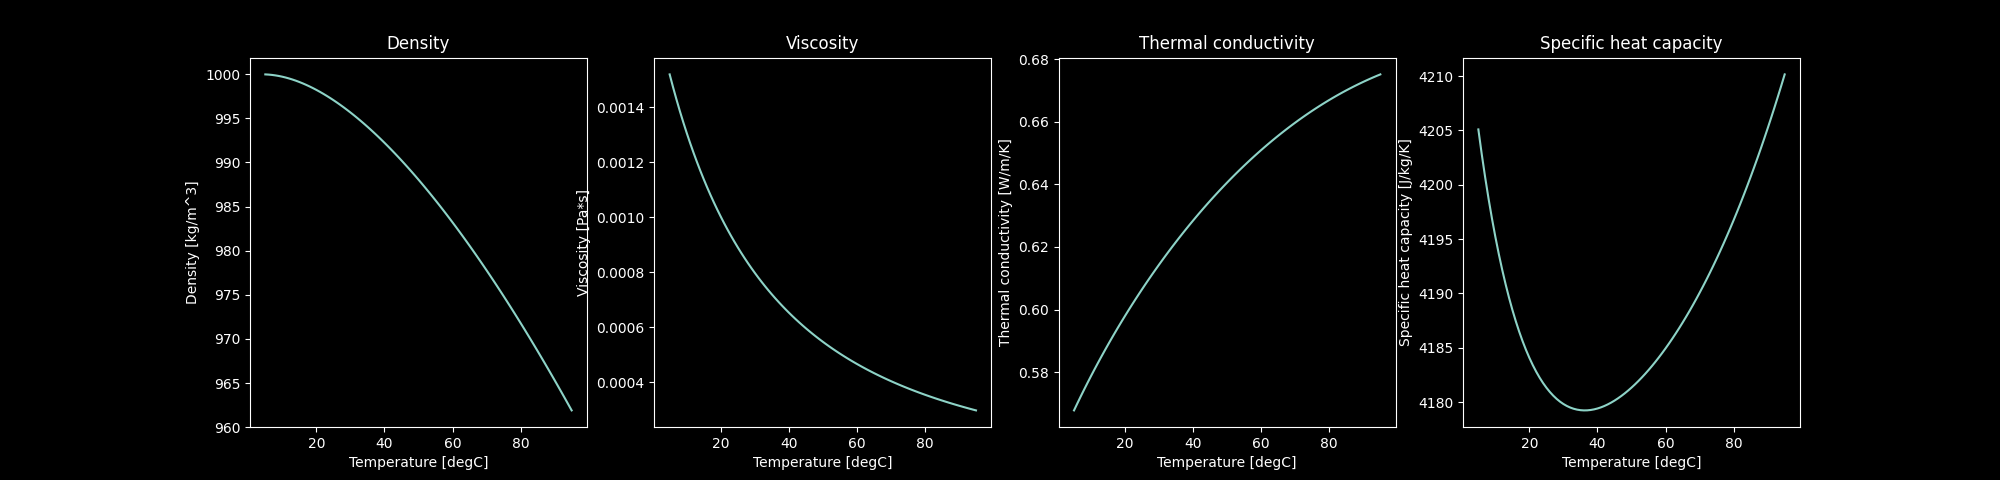

In [4]:
print(water.temperature)

figure_default_size = copy.copy(mpl.rcParams['figure.figsize'])
figure_default_size[0] = 20
figure_water_data = plt.figure(figsize=figure_default_size)

axes_density_data, axes_viscosity_data, axes_thermal_conductivity_data, axes_specific_heat_capacity_data = figure_water_data.subplots(1, 4)
print(mpl.rcParams['axes.titlepad'])

axes_density_data.plot(water.temperature, water.rho_lt)
axes_density_data.set_xlabel('Temperature [degC]')
axes_density_data.set_ylabel('Density [kg/m^3]')
axes_density_data.set_title('Density')

axes_viscosity_data.plot(water.temperature, water.viscosity_lt)
axes_viscosity_data.set_xlabel('Temperature [degC]')
axes_viscosity_data.set_ylabel('Viscosity [Pa*s]')
axes_viscosity_data.set_title('Viscosity')

axes_thermal_conductivity_data.plot(water.temperature, water.k_lookuptable)
axes_thermal_conductivity_data.set_xlabel('Temperature [degC]')
axes_thermal_conductivity_data.set_ylabel('Thermal conductivity [W/m/K]')
axes_thermal_conductivity_data.set_title('Thermal conductivity')

axes_specific_heat_capacity_data.plot(water.temperature, water.cp_lookuptable)
axes_specific_heat_capacity_data.set_xlabel('Temperature [degC]')
axes_specific_heat_capacity_data.set_ylabel('Specific heat capacity [J/kg/K]')
axes_specific_heat_capacity_data.set_title('Specific heat capacity')



In [5]:
class steel:
    density: float = 7800.0 # kg/m^3
    specific_heat_capacity: float = 450.0 # J/kg/K

class heat_exchanger:
    product_surface: float = 10.0 # m^2
    air_surface: float = 11.0 # m^2
    metal_weight: float = 230.0 # kg

    water_pipe_length: float = 1.0 # m
    water_pipe_radius: float = 0.01 # m

    water_metal_heat_transfer_coefficient: float = 0.0 # W/m^2/K
    metal_air_heat_transfer_coefficient: float = 0.0 # W/m^2/K
    metal_product_heat_transfer_coefficient: float = 0.0 # W/m^2/K

class discretization:
    nodes: int = 20
    time_step: float = 0.005 # s/step

class product:
    specific_heat_capacity: float = 3890.0 # J/kg/K
    mass: float = 100.0 # kg

class water_node:
    surface_metal: float = pi * heat_exchanger.water_pipe_radius * 2 * heat_exchanger.water_pipe_length / discretization.nodes # m^2
    volume: float = pi * heat_exchanger.water_pipe_radius ** 2 * heat_exchanger.water_pipe_length / discretization.nodes # m^3
    def mass(temperature_degC) -> float:
        return water.rho(temperature_degC) * pi * heat_exchanger.water_pipe_radius**2 * heat_exchanger.water_pipe_length / discretization.nodes

class metal_node:
    surface_product: float = heat_exchanger.product_surface / discretization.nodes
    surface_air: float = heat_exchanger.air_surface / discretization.nodes
    volume: float = heat_exchanger.metal_weight / steel.density / discretization.nodes
    mass: float = heat_exchanger.metal_weight / discretization.nodes


In [6]:
# Conduction heat rate formula
def heat_rate_conduction_boundary(origin_temperature: float, destiny_temperature: float, transfer_surface: float, transfer_coefficient: float) -> float:
    return transfer_surface * transfer_coefficient * (origin_temperature - destiny_temperature)

# Temperature change formula
def next_temperature(previous_temperature: float, heat_rate: float, specific_heat_capacity: float, mass: float) -> float:
    return previous_temperature + heat_rate / (specific_heat_capacity * mass)


In [7]:
input_water_temperature = 70 # degC
air_temperature = 25.0 # degC
starting_water_temperature = 25.0 # degC
starting_metal_temperature = 25.0 # degC
starting_product_temperature = 25.0 # degC
water_flow_rate = 0.1 # kg/s
simulation_time = 20 # s

In [8]:
class Simulador01Data:
    nodes_wm_h = np.zeros(discretization.nodes, dtype=np.float64) # W
    nodes_ww_h = np.zeros(discretization.nodes, dtype=np.float64) # W
    nodes_ma_h = np.zeros(discretization.nodes, dtype=np.float64) # W
    nodes_mp_h = np.zeros(discretization.nodes, dtype=np.float64) # W

    nodes_w_t  = np.full(discretization.nodes + 1, starting_water_temperature, dtype=float) # degC
    nodes_m_t  = np.full(discretization.nodes, starting_metal_temperature, dtype=float) # degC

    p_t = np.full(1, starting_product_temperature, dtype=float) # degC
    
    water_flow_rate = water_flow_rate # kg/s
    input_water_temperature = input_water_temperature # degC
    nodes_w_t[0] = input_water_temperature
    air_temperature = air_temperature # degC

In [9]:
class Simulador01DataShapes:
    nodes_wm_h = Simulador01Data.nodes_wm_h.shape
    nodes_ww_h = Simulador01Data.nodes_ww_h.shape
    nodes_ma_h = Simulador01Data.nodes_ma_h.shape
    nodes_mp_h = Simulador01Data.nodes_mp_h.shape

    nodes_w_t = Simulador01Data.nodes_w_t.shape
    nodes_m_t = Simulador01Data.nodes_m_t.shape

    p_t = Simulador01Data.p_t.shape

class Simulador01DataSizes:
    nodes_wm_h = Simulador01Data.nodes_wm_h.nbytes
    nodes_mp_h = Simulador01Data.nodes_mp_h.nbytes
    nodes_ww_h = Simulador01Data.nodes_ww_h.nbytes
    nodes_ma_h = Simulador01Data.nodes_ma_h.nbytes

    nodes_w_t = Simulador01Data.nodes_w_t.nbytes
    nodes_m_t = Simulador01Data.nodes_m_t.nbytes

    p_t = Simulador01Data.p_t.nbytes


In [10]:
@ray.remote
def heat_wm(i):
    multiprocessing.shared_memory.SharedMemory(name='nodes_wm_h', create=True, size=Simulador01DataSizes.nodes_wm_h)
    
    ref_nodes_w_t = multiprocessing.shared_memory.SharedMemory(name='nodes_w_t', size=Simulador01DataSizes.nodes_w_t)
    nodes_w_t = np.ndarray(Simulador01DataShapes.nodes_w_t, dtype=np.float64, buffer=ref_nodes_w_t.buf)
    ref_nodes_m_t = multiprocessing.shared_memory.SharedMemory(name='nodes_m_t', size=Simulador01DataSizes.nodes_m_t)
    nodes_m_t = np.ndarray(Simulador01DataShapes.nodes_m_t, dtype=np.float64, buffer=ref_nodes_m_t.buf)
    ref_nodes_wm_h = multiprocessing.shared_memory.SharedMemory(name='nodes_wm_h', size=Simulador01DataSizes.nodes_wm_h)
    nodes_wm_h = np.ndarray(Simulador01DataShapes.nodes_m_t, dtype=np.float64, buffer=ref_nodes_wm_h.buf)
    nodes_wm_h[i] = heat_rate_conduction_boundary(nodes_w_t[i], nodes_m_t[i], water_node.surface_metal, heat_exchanger.water_metal_heat_transfer_coefficient)


@ray.remote
def heat_ww(i):
    ref_nodes_w_t = multiprocessing.shared_memory.SharedMemory(name='nodes_w_t', size=Simulador01DataSizes.nodes_w_t)
    nodes_w_t = np.ndarray(Simulador01DataShapes.nodes_w_t, dtype=np.float64, buffer=ref_nodes_w_t.buf)
    
        
            # nodes_ww_h[i] = water_flow_rate * water.cp(nodes_w_t[i+1]) * (self.nodes_w_t[i] - self.nodes_w_t[i+1]) * discretization.time_step
            # self.nodes_ma_h[i] = heat_rate_conduction_boundary(self.nodes_m_t[i], self.air_temperature, metal_node.surface_air, heat_exchanger.metal_air_heat_transfer_coefficient)
            # self.nodes_mp_h[i] = heat_rate_conduction_boundary(self.nodes_m_t[i], self.p_t, metal_node.surface_product, heat_exchanger.metal_product_heat_transfer_coefficient)

            # self.p_t = self.p_t + np.sum(self.nodes_mp_h) * discretization.time_step / (product.specific_heat_capacity * product.mass)
            # self.nodes_m_t[i] = next_temperature(self.nodes_m_t[i], self.nodes_wm_h[i] - self.nodes_ma_h[i] - self.nodes_mp_h[i], steel.specific_heat_capacity, heat_exchanger.metal_weight)
            # self.nodes_w_t[i+1] = next_temperature(self.nodes_w_t[i+1], (- self.nodes_wm_h[i] + self.nodes_ww_h[i]), water.cp(self.nodes_w_t[i+1]), water.rho(self.nodes_w_t[i+1]) * water_node.volume)

In [15]:
class Simulator01 (Simulador01Data):
    def __init__(self):
        
        super().__init__()
        

    def step(self):

        for i in range(0, discretization.nodes):
            self.nodes_wm_h[i] = heat_rate_conduction_boundary(self.nodes_w_t[i], self.nodes_m_t[i], water_node.surface_metal, heat_exchanger.water_metal_heat_transfer_coefficient)
            self.nodes_ww_h[i] = self.water_flow_rate * water.cp(self.nodes_w_t[i+1]) * (self.nodes_w_t[i] - self.nodes_w_t[i+1]) * discretization.time_step
            self.nodes_ma_h[i] = heat_rate_conduction_boundary(self.nodes_m_t[i], self.air_temperature, metal_node.surface_air, heat_exchanger.metal_air_heat_transfer_coefficient)
            self.nodes_mp_h[i] = heat_rate_conduction_boundary(self.nodes_m_t[i], self.p_t, metal_node.surface_product, heat_exchanger.metal_product_heat_transfer_coefficient)

            self.p_t = self.p_t + np.sum(self.nodes_mp_h) * discretization.time_step / (product.specific_heat_capacity * product.mass)
            self.nodes_m_t[i] = next_temperature(self.nodes_m_t[i], self.nodes_wm_h[i] - self.nodes_ma_h[i] - self.nodes_mp_h[i], steel.specific_heat_capacity, heat_exchanger.metal_weight)
            self.nodes_w_t[i+1] = next_temperature(self.nodes_w_t[i+1], (- self.nodes_wm_h[i] + self.nodes_ww_h[i]), water.cp(self.nodes_w_t[i+1]), water.rho(self.nodes_w_t[i+1]) * water_node.volume)


# Conduction heat rate formula
def heat_rate_conduction_boundary(origin_temperature: float, destiny_temperature: float, transfer_surface: float, transfer_coefficient: float) -> float:
    return transfer_surface * transfer_coefficient * (origin_temperature - destiny_temperature)

# Temperature change formula
def next_temperature(previous_temperature: float, heat_rate: float, specific_heat_capacity: float, mass: float) -> float:
    return previous_temperature + heat_rate / (specific_heat_capacity * mass)


@ray.remote
def calculate_heats_by_index(node_w_t: float, next_node_w_t: float, node_m_t: float, p_t: float):
    return water_node.surface_metal * heat_exchanger.water_metal_heat_transfer_coefficient * (node_w_t - node_m_t), \
        water_flow_rate * water.cp(next_node_w_t) * (node_w_t - next_node_w_t) * discretization.time_step, \
        metal_node.surface_air * heat_exchanger.metal_air_heat_transfer_coefficient * (node_m_t - air_temperature), \
        metal_node.surface_product * heat_exchanger.metal_product_heat_transfer_coefficient * (node_m_t - p_t)

@ray.remote
def calculate_next_temperatures_by_index(node_w_t, node_m_t, node_wm_h, node_ww_h, node_ma_h, node_mp_h):
    return node_m_t + node_wm_h - node_ma_h - node_mp_h / (steel.specific_heat_capacity * metal_node.mass), \
        node_w_t + (- node_wm_h + node_ww_h) / (water.cp(node_w_t) * water_node.volume * water.rho(node_w_t))

In [17]:
# Configurable variables

node_to_measure = 10

@dataclass
class data:
    product_temperature = []
    metal_temperature = []
    water_temperature = []
    time = []


simulator = Simulator01()

t1 = time.time()
t2 = time.time()

# Simulation steps calculated
print(f'Simulation steps: {int(simulation_time/discretization.time_step)}')
# Simulation time calculated
print(f'Simulation time: {simulation_time}s')

data.time.append(0 * discretization.time_step)
data.product_temperature.append(simulator.p_t)
data.metal_temperature.append(simulator.nodes_m_t[node_to_measure])
data.water_temperature.append(simulator.nodes_w_t[node_to_measure])

profiling_data_mean_ns = [0,0,0,0,0,0,0]
profiling_data_mean_us = [0,0,0,0,0,0,0]
profiling_data_accumulated_ns = [0,0,0,0,0,0,0]
profiling_data_accumulated_ms = [0,0,0,0,0,0,0]
profiling_data_accumulated_s = [0,0,0,0,0,0,0]
profiling_data_points = [0,0,0,0,0,0,0]

t = time.time()

save_data = {
    'temperature': []
}

for i in range(0, int(simulation_time/discretization.time_step)):
    futures = []
    for i in range(0, discretization.nodes):
        futures.append(calculate_heats_by_index.remote(simulator.nodes_w_t[i], simulator.nodes_w_t[i+1], simulator.nodes_m_t[i], simulator.p_t))
    
    results = ray.get(futures)
    futures = []
    for i in range(0, discretization.nodes):
        futures.append(calculate_next_temperatures_by_index.remote(simulator.nodes_w_t[i+1], simulator.nodes_m_t[i], results[i][0], results[i][1], results[i][2], results[i][3]))

    results = ray.get(futures)

    save_data['temperature'].append(results[10][0])

print(save_data['temperature'])

for i in range(0, len(profiling_data_mean_ns)):

    profiling_data_accumulated_ms[i] = profiling_data_accumulated_ns[i] / 1000000
    profiling_data_accumulated_s[i] = profiling_data_accumulated_ns[i] / 1000000000

    if profiling_data_points[i] > 0:
        profiling_data_mean_ns[i] = profiling_data_accumulated_ns[i] / profiling_data_points[i]
        profiling_data_mean_us[i] = profiling_data_mean_ns[i] / 1000


# Print profiling data for each point

for i in range(0, len(profiling_data_mean_ns)):
    if profiling_data_points[i] > 0:
        print(f"Profiling data for step {i}  -  Accumulated time: {profiling_data_accumulated_ms[i]:.2f} ms  -  Mean: {profiling_data_mean_us[i]:.4f} us")

print()


figure = plt.figure()
axes = figure.subplots(1,1)
product_temperature_line, = axes.plot(data.time, data.product_temperature, label="Product temperature")
metal_temperature_line, = axes.plot(data.time, data.metal_temperature, label="Metal temperature")
water_temperature_line, = axes.plot(data.time, data.water_temperature, label="Water temperature")

axes.set_xlabel("Time")
axes.set_ylabel("Temperature (degC)")
legend = axes.legend()

Simulation steps: 4000
Simulation time: 20s


KeyboardInterrupt: 